In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils 
from keras import backend as K 
from keras.datasets import cifar10
from keras.utils.vis_utils import plot_model
import sklearn.metrics
import itertools
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import models

In [9]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] #Defines the names of the different classes



(X_train, y_train), (X_test, y_test) = cifar10.load_data() #Load data into variables

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train = X_train / 255.0 
X_test = X_test / 255.0
y_train = np_utils.to_categorical(y_train) 
#y_test = np_utils.to_categorical(y_test)

In [ ]:
num_classes = int(len(class_names))

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 
model.add(layers.BatchNormalization())
model.add(Dropout(0.3)) 
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) 
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) 
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3)) 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.3)) 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
model.add(layers.BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3)) 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 
model.add(Dropout(0.3)) 
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(layers.BatchNormalization())
model.add(Dropout(0.5)) 
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(layers.BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3))) 
model.add(layers.BatchNormalization())
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

epochs = 100
lrate = 0.01 
decay = lrate/epochs
sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False) 
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32) 
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

In [12]:
def accPrint(predict,label):
  correct=0
  for i in range(len(predict)):
    if np.argmax(predict[i]) - label[i] == 0:
        correct +=1 
  acc = (correct/len(label))*100
  print(acc)

def plot_image(i, predictions_array, true_label, img):
  true_label, img = int(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = int(true_label[i])
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')



def plot_encoding_maps(x, model, nr_layer):
    y = x.copy()   #Save a copy of the original images
    
    #Compute the forward porpagation up to and including the specific layer output
    for i, layer in enumerate(model.layers):
        x = layer(x)
        if i == nr_layer:
            name_layer = "Layer {}".format(i+1)
            break
    
    #Get the number of rows and columns for the figure
    n_rows = x.shape[0]
    n_cols = x.shape[-1] + 1
    
    #Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (16,10))
    fig.suptitle(name_layer)
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            if j == 0:
                #Plot the original images
                ax.imshow(y[i,:,:,0])
                plt.xlabel(class_names[int(y_test[i])])
                if i == 0:
                    ax.set_title("Input Image")
            else:
                #Plot the feature map
                ax.imshow(x[i, :, :, j-1], cmap = "magma")
                if i == 0 and j == (n_cols - 1)//2:
                    ax.set_title("Feature Maps")
    return


def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

Functions used in post processing

In [5]:
model = models.load_model('FinalModel.h5')

313/313 [==============================] - 7s 22ms/step
82.93


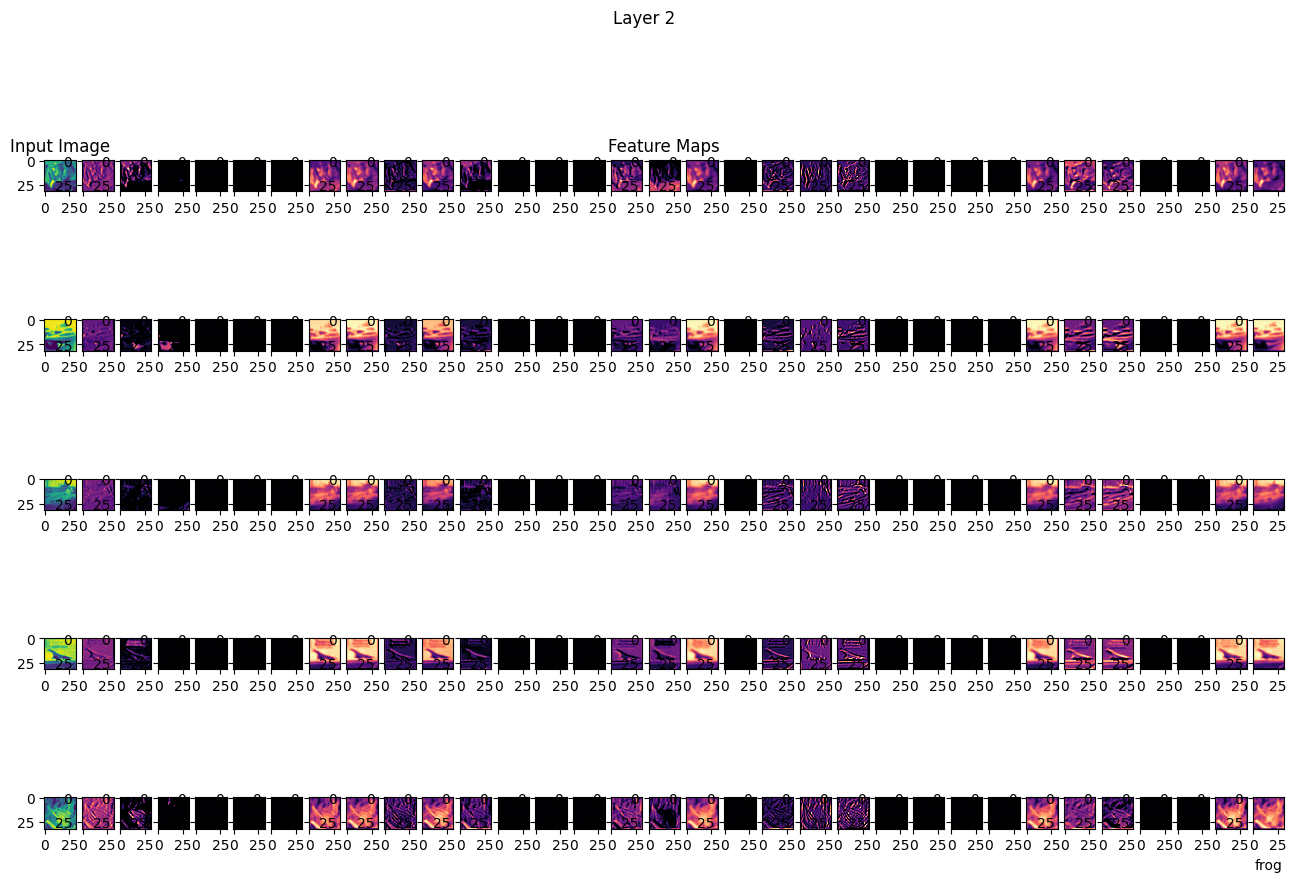

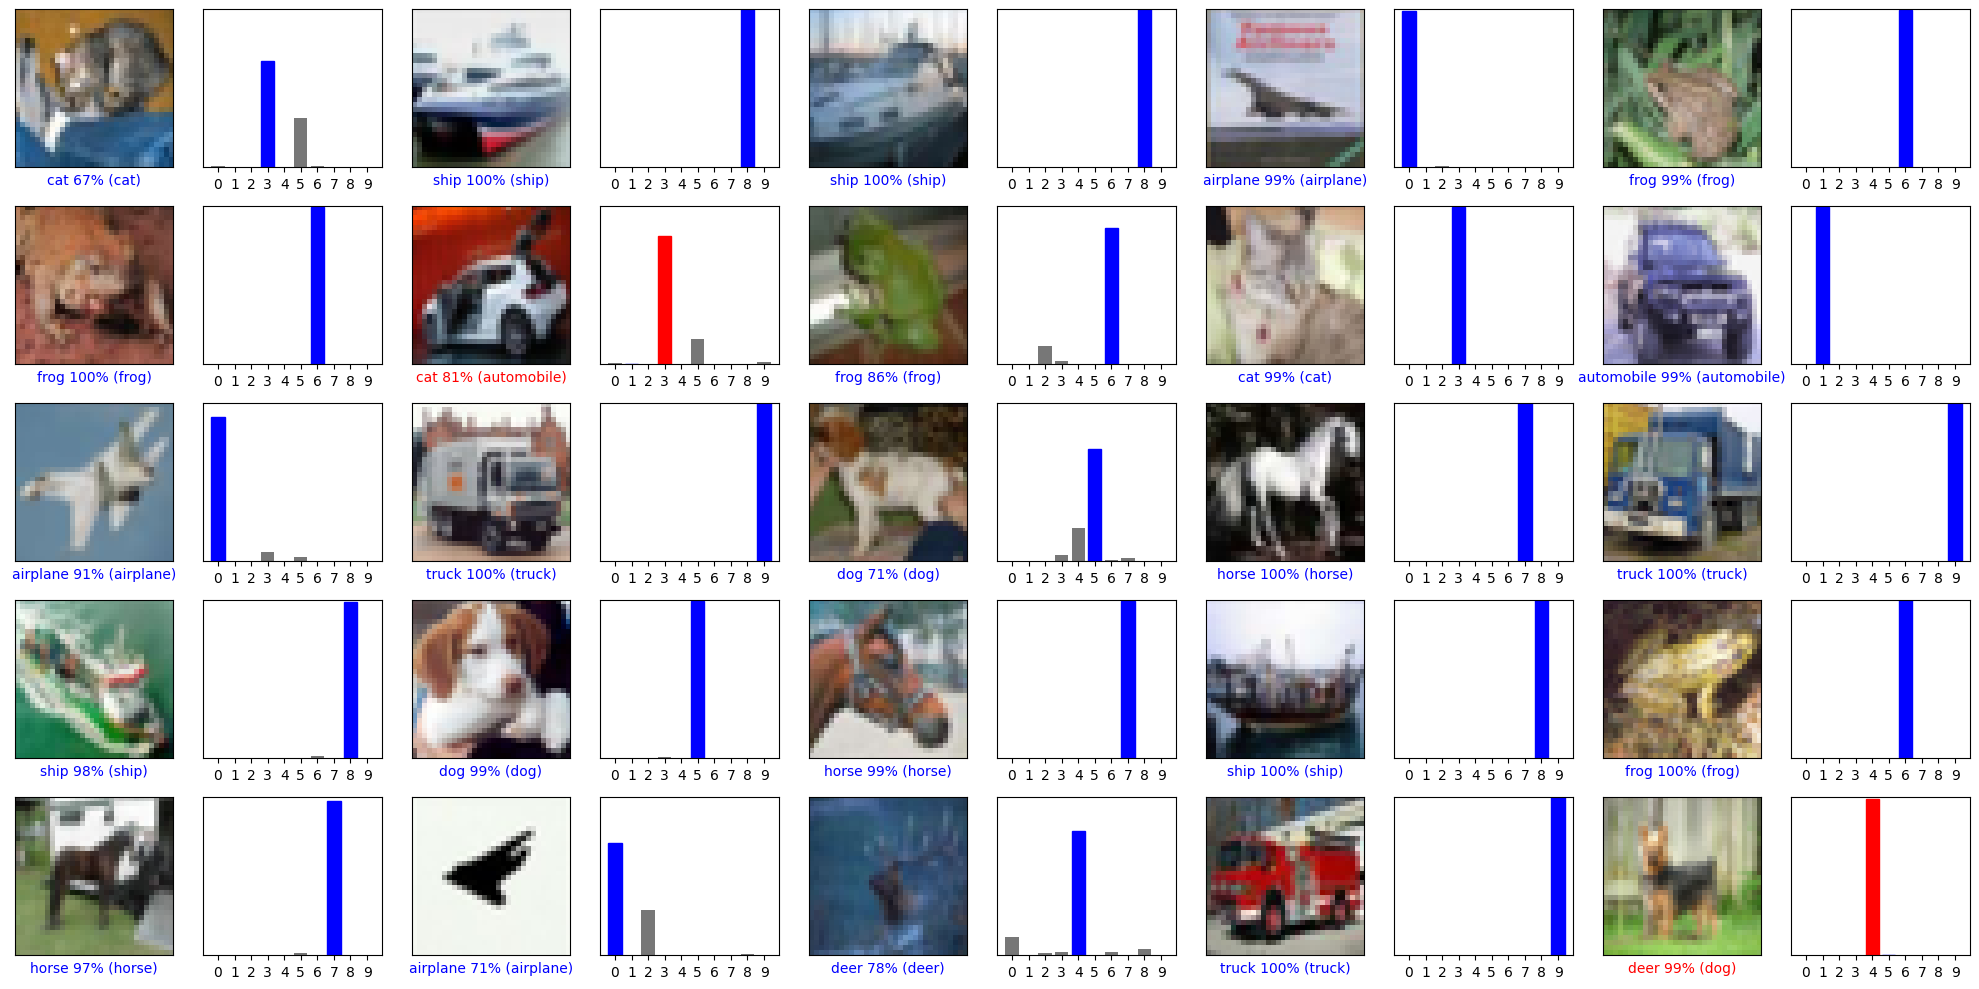

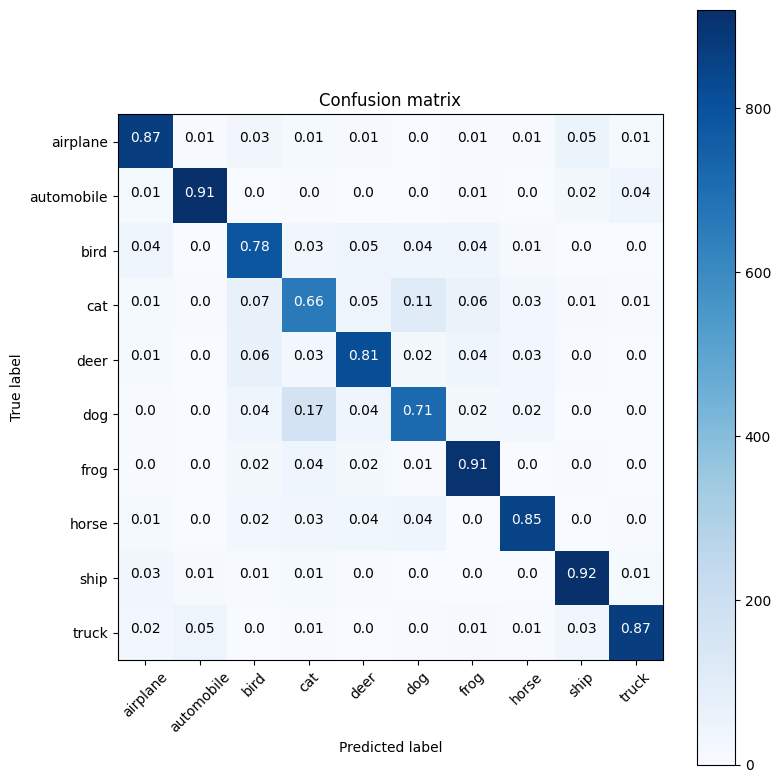

In [15]:


#prediction of test images
prediction = model.predict(X_test)

accPrint(prediction,y_test)


#plotting of feature maps
x_sample = X_test[:5]
plot_encoding_maps(x_sample, model, 1)


#
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, prediction[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, prediction[i], y_test)
plt.tight_layout()




cm = sklearn.metrics.confusion_matrix(y_test, np.argmax(prediction, axis=1))
plot_confusion_matrix(cm,class_names)
plt.show()